In [1]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5MB 252kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9MB 131kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.3MB 160kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1MB 13.8MB/s 
     |████████████████████████████████| 184kB 8.2MB/s 
     |████████████████████████████████| 235kB 17.3MB/s 
     |████████████████████████████████| 2.2MB 20.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=c05c165b488213320dcb3a577eb0e0ad46998c6089bf5c11a5ee27b6782797ed
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Su

In [2]:
%cd /content/drive/My\ Drive/fueki/GNN

/content/drive/My Drive/fueki/GNN


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset

from sklearn.preprocessing import LabelEncoder

## グラフ変換前のデータ

In [4]:
df = pd.read_csv('./dataset/RecSys/yoochoose-clicks.dat', header=None)
df.columns=['session_id', 'timestamp', 'item_id', 'category']

buy_df = pd.read_csv('./dataset/RecSys/yoochoose-buys.dat', header=None)
buy_df.columns=['session_id', 'timestamp', 'item_id', 'price', 'quantity']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0
...,...,...,...,...
33003939,11299809,2014-09-25T09:33:22.412Z,214819412,S
33003940,11299809,2014-09-25T09:43:52.821Z,214830939,S
33003941,11299811,2014-09-24T19:02:09.741Z,214854855,S
33003942,11299811,2014-09-24T19:02:11.894Z,214854838,S


In [6]:
df = df[df['session_id'].isin(df.query('item_id == 214819412').session_id.tolist())]

In [7]:
np.random.seed(0)
sampled_session_id = np.random.choice(df.session_id.unique(), 100, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)].reset_index(drop=True)
buy_df = buy_df.loc[buy_df.session_id.isin(df.session_id)].reset_index(drop=True)
df.nunique()

session_id    100
timestamp     456
item_id       183
category        7
dtype: int64

In [8]:
item_encoder = LabelEncoder()
category_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df['category']= category_encoder.fit_transform(df.category.apply(str))
buy_df['item_id'] = item_encoder.transform(buy_df.item_id)

In [9]:
df.head()

,session_id,timestamp,item_id,category
0,80662,2014-04-06T16:00:03.122Z,32,0
1,80662,2014-04-06T16:03:18.548Z,12,0
2,80662,2014-04-06T16:09:19.599Z,32,0
3,80662,2014-04-06T16:15:06.446Z,42,0
4,80662,2014-04-06T16:25:07.799Z,42,0


In [10]:
buy_df.head()

,session_id,timestamp,item_id,price,quantity
0,8078528,2014-08-16T12:52:22.985Z,133,3141,1
1,9136218,2014-08-25T10:26:53.370Z,137,627,3
2,10465504,2014-09-14T14:55:47.641Z,36,470,1
3,10465504,2014-09-14T14:55:47.646Z,75,5549,1
4,10465504,2014-09-14T14:55:47.655Z,154,837,2


## Datasetの作成

In [29]:
class RecSysDataset(InMemoryDataset): 
    def __init__(self, root, name, df, buy_df, transform=None, pre_transform=None):
        self.root = root
        self.name = name
        self.df = df
        self.buy_df = buy_df
        super(RecSysDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return [self.root + self.name]

    def download(self):
        pass
    
    def process(self):
        data_list = []

        buy_id = np.unique(self.buy_df['session_id'].values)
        for session, group in self.df.groupby('session_id'):
            group = group.copy()
            node_id_encoder = LabelEncoder()
            nodes = node_id_encoder.fit_transform(group.item_id)
            group['node_id'] = nodes

            # node feature
            node_features = group[['item_id', 'node_id']].sort_values('node_id')[['item_id']].drop_duplicates().values
            x = torch.tensor(node_features, dtype=torch.long)

            # edge
            from_nodes = nodes[:-1]
            to_nodes = nodes[1:]
            edge_index = torch.tensor([from_nodes, to_nodes], dtype=torch.long)

            # target
            target = np.zeros(len(node_features))
            if session in buy_id:
                positive_flag = node_id_encoder.transform(self.buy_df.query('session_id == @session')['item_id'])
                target[positive_flag] = 1
            y = torch.tensor(target, dtype=torch.long)

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

### batch = 1の場合

In [30]:
dataset = RecSysDataset(root='/content/drive/My Drive/fueki/GNN/dataset/RecSys', 
                        name='/test.dataset',
                        df=df, 
                        buy_df=buy_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [13]:
data = next(iter(dataloader))

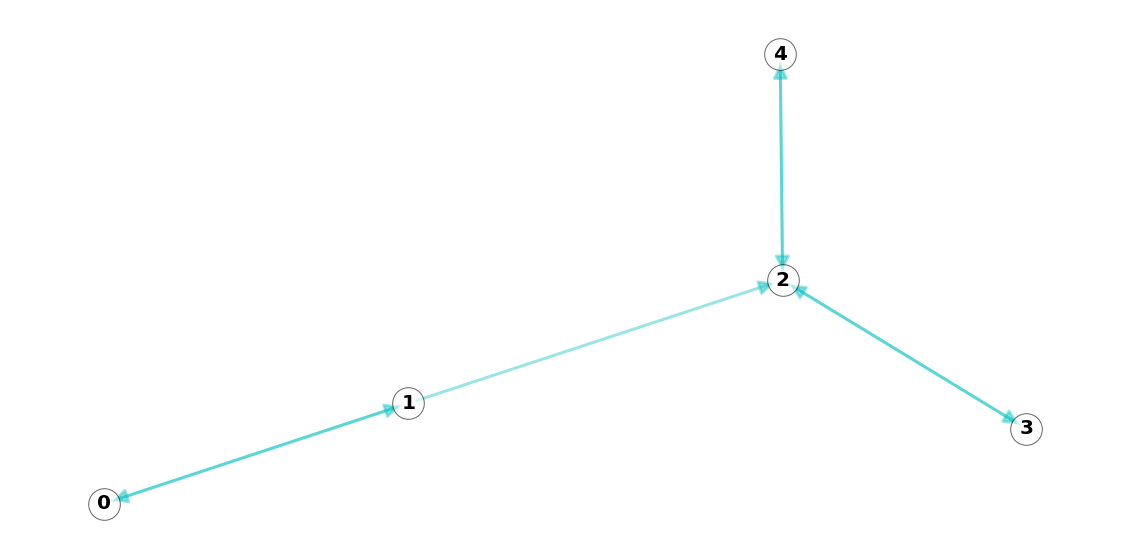

In [14]:
G = nx.DiGraph()
G.add_edges_from(data.edge_index.cpu().detach().numpy().T)

plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.8)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1000, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=20, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=3, arrowsize=30)
plt.show()

In [15]:
data.y

tensor([0, 0, 0, 0, 0])

In [16]:
data.x

tensor([[12],
        [32],
        [42],
        [50],
        [65]])

In [17]:
df.query('session_id == 80662')

,session_id,timestamp,item_id,category
0,80662,2014-04-06T16:00:03.122Z,32,0
1,80662,2014-04-06T16:03:18.548Z,12,0
2,80662,2014-04-06T16:09:19.599Z,32,0
3,80662,2014-04-06T16:15:06.446Z,42,0
4,80662,2014-04-06T16:25:07.799Z,42,0
5,80662,2014-04-06T16:28:54.002Z,65,0
6,80662,2014-04-06T16:42:14.015Z,42,0
7,80662,2014-04-06T16:47:49.564Z,50,0
8,80662,2014-04-06T16:48:00.462Z,42,0
9,80662,2014-04-06T16:51:29.754Z,42,0


### batch = 2の場合

In [18]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [19]:
data = next(iter(dataloader))
data

Batch(batch=[7], edge_index=[2, 11], x=[7, 1], y=[7])

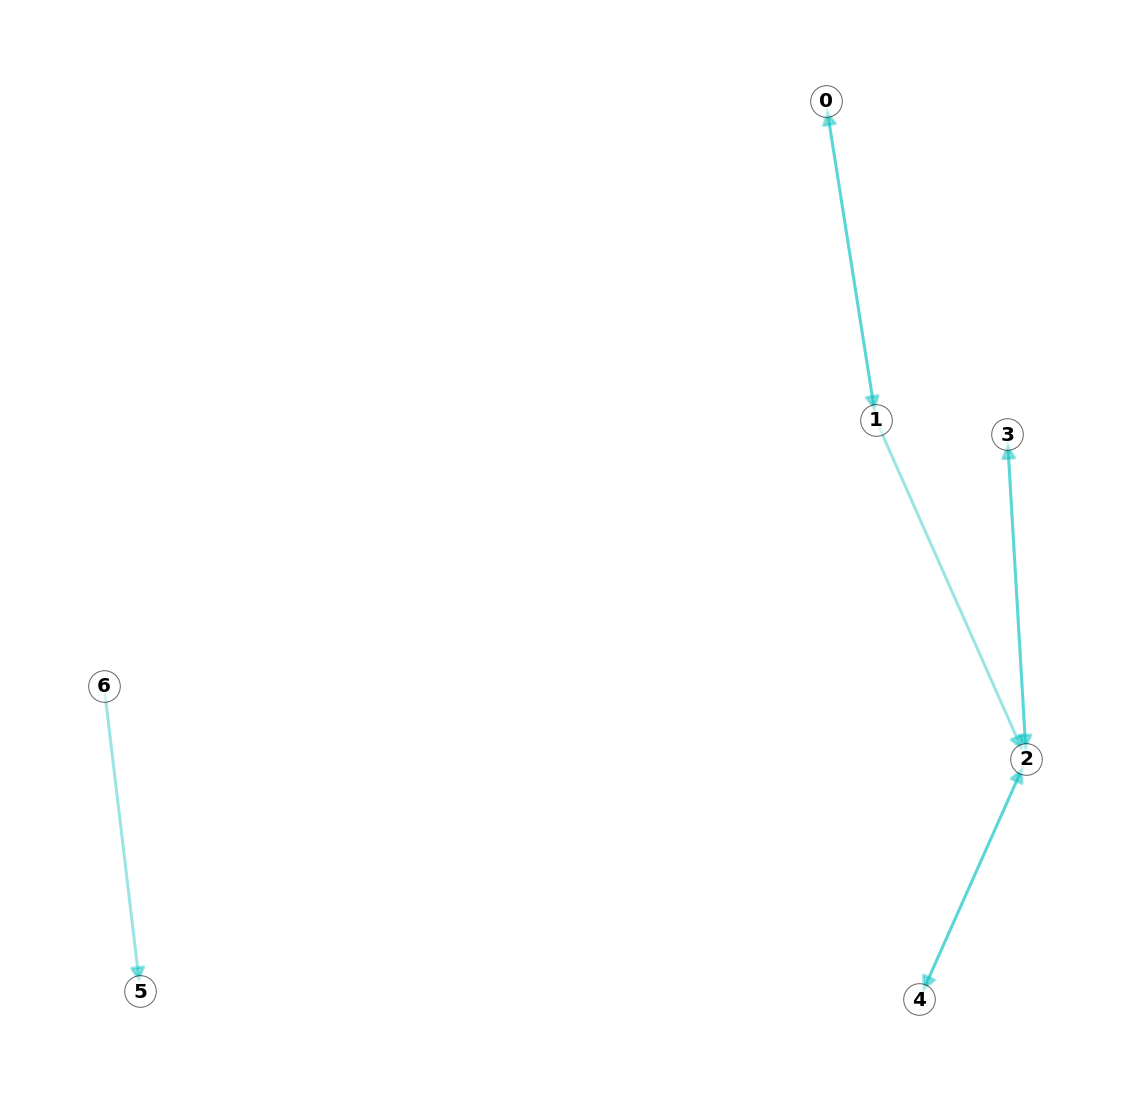

In [20]:
G = nx.DiGraph()
G.add_edges_from(data.edge_index.cpu().detach().numpy().T)

plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(G, k=0.6)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1000, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=20, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=3, arrowsize=30)
plt.show()

In [21]:
data.y

tensor([0, 0, 0, 0, 0, 0, 0])

In [22]:
data.x

tensor([[12],
        [32],
        [42],
        [50],
        [65],
        [42],
        [65]])

In [23]:
df[df['session_id'].isin(df['session_id'].drop_duplicates()[:2].values)]

,session_id,timestamp,item_id,category
0,80662,2014-04-06T16:00:03.122Z,32,0
1,80662,2014-04-06T16:03:18.548Z,12,0
2,80662,2014-04-06T16:09:19.599Z,32,0
3,80662,2014-04-06T16:15:06.446Z,42,0
4,80662,2014-04-06T16:25:07.799Z,42,0
5,80662,2014-04-06T16:28:54.002Z,65,0
6,80662,2014-04-06T16:42:14.015Z,42,0
7,80662,2014-04-06T16:47:49.564Z,50,0
8,80662,2014-04-06T16:48:00.462Z,42,0
9,80662,2014-04-06T16:51:29.754Z,42,0


- item_id = 42がグラフ間で重複しているが、別々のグラフになっている
- 特徴ベクトルにおいて、42の頂点が2つ存在しているため、うまくいっている

## model